In [1]:
!pip install pdfplumber
!pip install camelot-py[cv]
!pip install --upgrade pymupdf
!pip install google-generativeai
!pip install faiss-cpu
!pip install transformers tqdm pandas pytesseract pillow easyocr langchain langchain-community langchain_openai faiss-cpu rank_bm25 pdf2image
!pip install sentence_transformers
!pip install python-dotenv

  Obtaining dependency information for pdfplumber from https://files.pythonhosted.org/packages/12/28/3958ed81a9be317610ab73df32f1968076751d651c84dff1bcb45b7c6c0e/pdfplumber-0.11.8-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/43.6 kB ? eta -:--:--
     ----------------- -------------------- 20.5/43.6 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 43.6/43.6 kB 529.5 kB/s eta 0:00:00
  Obtaining dependency information for pdfminer.six==20251107 from https://files.pythonhosted.org/packages/64/29/d1d9f6b900191288b77613ddefb73ed35b48fb35e44aaf8b01b0422b759d/pdfminer_six-20251107-py3-none-any.whl.metadata
  Obtaining dependency information for Pillow>=9.1 from https://files.pythonhosted.org/packages/4d/42/aaca386de5cc8bd8a0254516957c1f265e3521c91515b16e286c662854c4/pillow-12.0.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pypdfium2>=4.18.0 from https://files.pythonhosted.org/packages/21/46/21de463f575a85dc8973


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for camelot-py[cv] from https://files.pythonhosted.org/packages/94/01/fffe89adaf51f7c2584d087aaafd260ed2d44b977bb795444b16d500ec5e/camelot_py-1.0.9-py3-none-any.whl.metadata
  Obtaining dependency information for click>=8.0.1 from https://files.pythonhosted.org/packages/98/78/01c019cdb5d6498122777c1a43056ebb3ebfeef2076d9d026bfe15583b2b/click-8.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for chardet>=5.1.0 from https://files.pythonhosted.org/packages/38/6f/f5fbc992a329ee4e0f288c1fe0e2ad9485ed064cac731ed2fe47dcc38cbf/chardet-5.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.24.4 from https://files.pythonhosted.org/packages/aa/44/9fe81ae1dcc29c531843852e2874080dc441338574ccc4306b39e2ff6e59/numpy-2.3.5-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.9 kB 1.3 MB/s eta 0:00:01
     --------------


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for pymupdf from https://files.pythonhosted.org/packages/f9/e8/989f4eaa369c7166dc24f0eaa3023f13788c40ff1b96701f7047421554a8/pymupdf-1.26.6-cp310-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/18.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/18.4 MB 812.7 kB/s eta 0:00:23
    --------------------------------------- 0.5/18.4 MB 4.0 MB/s eta 0:00:05
   - -------------------------------------- 0.7/18.4 MB 4.6 MB/s eta 0:00:04
   -- ------------------------------------- 1.1/18.4 MB 5.4 MB/s eta 0:00:04
   --- ------------------------------------ 1.4/18.4 MB 5.5 MB/s eta 0:00:04
   --- ------------------------------------ 1.7/18.4 MB 5.6 MB/s eta 0:00:03
   ---- ----------------------------------- 2.0/18.4 MB 5.9 MB/s eta 0:00:03
   ---- ----------------------------------- 2.3/18.4 MB 5.8 MB/s eta 0:00:03
   ----- -------------------------


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for google-generativeai from https://files.pythonhosted.org/packages/6e/40/c42ff9ded9f09ec9392879a8e6538a00b2dc185e834a3392917626255419/google_generativeai-0.8.5-py3-none-any.whl.metadata
  Obtaining dependency information for google-ai-generativelanguage==0.6.15 from https://files.pythonhosted.org/packages/7c/a3/67b8a6ff5001a1d8864922f2d6488dc2a14367ceb651bc3f09a947f2f306/google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata
  Obtaining dependency information for google-api-core from https://files.pythonhosted.org/packages/ed/d4/90197b416cb61cefd316964fd9e7bd8324bcbafabf40eef14a9f20b81974/google_api_core-2.28.1-py3-none-any.whl.metadata
  Obtaining dependency information for google-api-python-client from https://files.pythonhosted.org/packages/96/58/c1e716be1b055b504d80db2c8413f6c6a890a6ae218a65f178b63bc30356/google_api_python_client-2.187.0-py3-none-any.whl.metadata
  Obtaining dependency information for google-auth>=2.15.0 from https://file


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for faiss-cpu from https://files.pythonhosted.org/packages/5e/9c/3018e755701023789af060ad926bf99f147fa76488ddf1e181735afe93eb/faiss_cpu-1.13.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/18.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/18.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/18.7 MB 2.8 MB/s eta 0:00:07
    --------------------------------------- 0.4/18.7 MB 4.4 MB/s eta 0:00:05
   - -------------------------------------- 0.8/18.7 MB 5.6 MB/s eta 0:00:04
   -- ------------------------------------- 1.1/18.7 MB 5.7 MB/s eta 0:00:04
   -- ------------------------------------- 1.4/18.7 MB 6.0 MB/s eta 0:00:03
   --- ------------------------------------ 1.7/18.7 MB 6.0 MB/s eta 0:00:03
   ---- ----------------------------------- 2.1/18.7 MB 6.3 MB/s eta 0:00:03
   ---- ----------------------------------- 2.3/18.7 MB 6.2 MB/s eta 0:00:03
   ----- ----------------------


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/71/d3/c16c3b3cf7655a67db1144da94b021c200ac1303f82428f2beef6c2e72bb/transformers-4.57.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/44.0 kB ? eta -:--:--
     ----------------- -------------------- 20.5/44.0 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 44.0/44.0 kB 535.7 kB/s eta 0:00:00
  Obtaining dependency information for pytesseract from https://files.pythonhosted.org/packages/7a/33/8312d7ce74670c9d39a532b2c246a853861120486be9443eebf048043637/pytesseract-0.3.13-py3-none-any.whl.metadata
  Obtaining dependency information for easyocr from https://files.pythonhosted.org/packages/bb/84/4a2cab0e6adde6a85e7ba543862e5fc0250c51f3ac721a078a55cdcff250/easyocr-1.7.2-py3-none-any.whl.metadata
  Obtaining dependency information for langchain from https://files.pythonhosted.org/packages/8e/4a/02c14af46fa79ce7b02a0f8af46f5905cc7e8b647a5f1a7c793


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for sentence_transformers from https://files.pythonhosted.org/packages/bb/a6/a607a737dc1a00b7afe267b9bfde101b8cee2529e197e57471d23137d4e5/sentence_transformers-5.1.2-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/9f/71/34ddbd21f1da67c7a768146968b4d0220ee6831e4bcbad3e03dd3eae88b6/scikit_learn-1.7.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/1e/e8/685f47e0d754320684db4425a0967f7d3fa70126bffd76110b7009a0090f/joblib-1.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/32/d5/f9a850d79b0851d1d4ef6456097579a9005b31fea68726a4ae5f2d82ddd9/threadpoolctl-3.6.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/488.0 kB ? eta -:--:--
   ---------------------- ----------------- 276.5/488.0 kB 8.6


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from dotenv import load_dotenv
import re
import os, glob
import pdfplumber
import camelot
import pymupdf
import numpy as np
import pandas as pd
from pathlib import Path
import time
import faiss, json
import collections
import fitz
import io
from PIL import Image
import pytesseract
from langchain_core.documents import Document
from openai import OpenAI
from TableRetrieval.table_ingestion import stage1_extract_and_save
from TableRetrieval.table_ingestion import store_in_faiss, save_metadata_mapping
from TableRetrieval.table_agentic_rag import TableAgenticRAG

load_dotenv()

c:\Users\imman\Github\PTO\.venv\Lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


True

# Agent CFO — Performance Optimization & Design

---
This is the starter notebook for your project. Follow the required structure below.


You will design and optimize an Agent CFO assistant for a listed company. The assistant should answer finance/operations questions using RAG (Retrieval-Augmented Generation) + agentic reasoning, with response time (latency) as the primary metric.

Your system must:
*   Ingest the company’s public filings.
*   Retrieve relevant passages efficiently.
*   Compute ratios/trends via tool calls (calculator, table parsing).
*   Produce answers with valid citations to the correct page/table.


## 1. Config & Secrets

Fill in your API keys in secrets. **Do not hardcode keys** in cells.

In [3]:
import os

# Example:
# os.environ['GEMINI_API_KEY'] = 'your-key-here'
# os.environ['OPENAI_API_KEY'] = 'your-key-here'

COMPANY_NAME = "Google"

CHUNK_SIZE = 500  # number of words per chunk 

def generate_test_log_path_name(base_path: str): 
    # create the directory if not exist 
    os.makedirs(base_path, exist_ok=True) 
    existing_files = [f for f in os.listdir(base_path) if f.startswith("test_") and f.endswith(".json")] 
    existing_indices = [int(f.split("_")[1].split(".")[0]) for f in existing_files if f.split("_")[1].split(".")[0].isdigit()] 
    next_index = max(existing_indices) + 1 if existing_indices else 1 

    return f"{base_path}/test_{next_index}.json"


## 2. Data Download (Dropbox)

*   Annual Reports: last 3–5 years.
*   Quarterly Results Packs & MD&A (Management Discussion & Analysis).
*   Investor Presentations and Press Releases.
*   These files must be submitted later as a deliverable in the Dropbox data pack.
*   Upload them under `/content/data/`.

Scope limit: each team will ingest minimally 15 PDF files total.


In [4]:
DATA_DIR = "00-data"

# Annual reports (10-Ks)
annual_files = glob.glob(f"{DATA_DIR}/annuals/*.pdf")

# # Quarterly reports (10-Qs)
quarterly_files = glob.glob(f"{DATA_DIR}/quarterlies/*.pdf")

# Presentations
presentation_files = glob.glob(f"{DATA_DIR}/presentations/*.pdf")

In [5]:
for folder in ["annuals", "quarterlies", "presentations"]:

    files = glob.glob(f"{DATA_DIR}/{folder}/*.pdf")
    print(f"{folder}: {len(files)} files")

annuals: 3 files
quarterlies: 11 files
presentations: 2 files


## 3. System Requirements

**Retrieval & RAG**
*   Use a vector index (e.g., FAISS, LlamaIndex) + a keyword filter (BM25/ElasticSearch).
*   Citations must include: report name, year, page number, section/table.

**Agentic Reasoning**
*   Support at least 3 tool types: calculator, table extraction, multi-document compare.
*   Reasoning must follow a plan-then-act pattern (not a single unstructured call).

**Instrumentation**
*   Log timings for: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total.
*   Log: tokens used, cache hits, tools invoked.
*   Record p50/p95 latencies.

### Embeddings

In [6]:
def create_embeddings(chunks, model="text-embedding-3-small"):
    """
    Create embeddings for chunks using OpenAI.
    Returns: chunks with 'embedding' field added
    """
    print(f"Creating embeddings with {model}...\n")
    print(f"   Total chunks: {len(chunks)}")
    
    client = OpenAI()

    # Split into batches of 50
    batch_size = 50
    total_batches = (len(chunks) + batch_size - 1) // batch_size

    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i + batch_size]
        batch_num = i // batch_size + 1
        print(f"   Processing batch {batch_num} of {total_batches}...")

        contents = [chunk['content'] for chunk in batch]
        
        # Embed batch
        response = client.embeddings.create(
            model=model,
            input=contents
        )
        
        # Add embeddings to chunks
        for j, chunk in enumerate(batch):
            chunk['embedding'] = response.data[j].embedding

        # Small delay to respect rate limits
        if i + batch_size < len(chunks):
                time.sleep(0.6) # Adjust as needed
    
    print(f"Created {len(chunks)} embeddings\n")
    return chunks

### Table Ingestion

In [7]:
def stage2_create_embeddings(json_file):
    """
    Load extracted tables from JSON and create embeddings.
    This is where you spend OpenAI tokens.
    """
    load_dotenv()
    
    DATA_DIR = "00-data"
    
    print("="*80)
    print("STAGE 2: CREATING EMBEDDINGS")
    print("="*80)
    print()
    
    # Load the extracted tables
    print(f"Loading: {json_file}")
    with open(json_file, 'r') as f:
        table_chunks = json.load(f)
    
    print(f"Loaded {len(table_chunks)} tables")
    
    print("\nCreating embeddings...")
    embedded_chunks = create_embeddings(table_chunks)
    
    print("\nStoring in FAISS...")
    faiss_index = store_in_faiss(
        embedded_chunks,
        faiss_index_path=f"{DATA_DIR}/base/faiss_table_index"
    )
    
    print("\nSaving metadata...")
    save_metadata_mapping(
        embedded_chunks,
        mapping_path=f"{DATA_DIR}/base/faiss_table_metadata.json"
    )
    
    print(f"\n{'='*80}")
    print("COMPLETE!")
    print("="*80)
    print(f"FAISS index: {DATA_DIR}/base/faiss_table_index")
    print(f"Metadata: {DATA_DIR}/base/faiss_table_metadata.json")
    print()

In [8]:
# Insert table ingestion code here
stage1_extract_and_save()

STAGE 1: EXTRACTING TABLES FROM PDFs


annuals: 3 files
  Processing: 00-data/annuals\goog-10-k-2022.pdf
    → Extracted 76 tables
  Processing: 00-data/annuals\goog-10-k-2023-final.pdf
    → Extracted 69 tables
  Processing: 00-data/annuals\goog-10-k-2024.pdf
    → Extracted 69 tables

quarterlies: 11 files
  Processing: 00-data/quarterlies\goog-10-q-q1-2022.pdf
    → Extracted 66 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2023.pdf
    → Extracted 70 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2024.pdf
    → Extracted 65 tables
  Processing: 00-data/quarterlies\goog-10-q-q1-2025.pdf
    → Extracted 78 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2022.pdf
    → Extracted 71 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2023.pdf
    → Extracted 75 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2024.pdf
    → Extracted 81 tables
  Processing: 00-data/quarterlies\goog-10-q-q2-2025.pdf
    → Extracted 86 tables
  Processing: 00-data/quarterlies\

('00-data/extracted_tables.json', 1036)

In [9]:
stage2_create_embeddings(f"{DATA_DIR}/extracted_tables.json")

STAGE 2: CREATING EMBEDDINGS

Loading: 00-data/extracted_tables.json
Loaded 1036 tables

Creating embeddings...
Creating embeddings with text-embedding-3-small...

   Total chunks: 1036
   Processing batch 1 of 21...
   Processing batch 2 of 21...
   Processing batch 3 of 21...
   Processing batch 4 of 21...
   Processing batch 5 of 21...
   Processing batch 6 of 21...
   Processing batch 7 of 21...
   Processing batch 8 of 21...
   Processing batch 9 of 21...
   Processing batch 10 of 21...
   Processing batch 11 of 21...
   Processing batch 12 of 21...
   Processing batch 13 of 21...
   Processing batch 14 of 21...
   Processing batch 15 of 21...
   Processing batch 16 of 21...
   Processing batch 17 of 21...
   Processing batch 18 of 21...
   Processing batch 19 of 21...
   Processing batch 20 of 21...
   Processing batch 21 of 21...
Created 1036 embeddings


Storing in FAISS...
Stored 1036 vectors in FAISS index at '00-data/base/faiss_table_index'


Saving metadata...
Saved metadat

### Slides Ingestion

In [11]:
from ImageRetrieval.ImageRetrieval import ImageRetriever
from ImageRetrieval.slides_extractor import extract_slides_fitz
from ImageRetrieval.ocr_extractor import ocr_folder
from ImageRetrieval.image_faiss_builder import (
    create_image_embeddings,
    store_image_faiss,
    save_image_metadata
)

IMAGE_INDEX_PATH = "00-data/base/faiss_image_index"
IMAGE_META_PATH  = "00-data/base/faiss_image_metadata.json"

slide_docs = []

pdf_files = glob.glob("00-data/presentations/*.pdf")
print(f"[ImagePipeline] Found {len(pdf_files)} presentation PDFs.")

for pdf in pdf_files:
    pdf_name = os.path.splitext(os.path.basename(pdf))[0]
    out_dir = f"00-data/presentations/slides_{pdf_name}"

    extract_slides_fitz(pdf, out_dir)
    slide_docs.extend(ocr_folder(out_dir, label=pdf_name))

print(f"[ImagePipeline] Total OCR slide documents: {len(slide_docs)}")

# Embed
embeddings = create_image_embeddings(slide_docs)

# FAISS + metadata
store_image_faiss(embeddings, IMAGE_INDEX_PATH)
save_image_metadata(slide_docs, IMAGE_META_PATH)


[ImagePipeline] Found 2 presentation PDFs.
[SlidesExtractor] Loaded 00-data/presentations\2025q1-alphabet-earnings-slides.pdf (10 pages)
[SlidesExtractor] Extracted 10 slides
[OCR] Loaded 10 OCR docs from 00-data/presentations/slides_2025q1-alphabet-earnings-slides
[SlidesExtractor] Loaded 00-data/presentations\2025q2-alphabet-earnings-slides.pdf (10 pages)
[SlidesExtractor] Extracted 10 slides
[OCR] Loaded 10 OCR docs from 00-data/presentations/slides_2025q2-alphabet-earnings-slides
[ImagePipeline] Total OCR slide documents: 20
[FAISS] Saved index → 00-data/base/faiss_image_index
[FAISS] Saved metadata → 00-data/base/faiss_image_metadata.json


### Text Ingestion

In [ ]:
from TextRetrieval.TextExtractor import extract_text_from_pdf
extract_text_from_pdf(); 


## TEXT FAISS BUILDER
### CREATE THE CHUNKS 
### BUILD THE INDICES BASE OFF THE CHUNKS

In [ ]:
from TextRetrieval.TextFaissBuilder import create_chunks, built_indices

chunks = create_chunks();
built_indices(chunks); 

## 4. Baseline Pipeline

**Baseline (starting point)**
*   Naive chunking.
*   Single-pass vector search.
*   One LLM call, no caching.

In [ ]:
# TODO: Implement baseline retrieval + generation


## 5. Benchmark Runner

Run these 3 standardized queries. Produce JSON then prose answers with citations. These are the standardized queries.

*   Gross Margin Trend (or NIM if Bank)
    *   Query: "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values."
    *   Expected Output: A quarterly table of Gross Margin % (or NIM % if bank).

*   Operating Expenses (Opex) YoY for 3 Years
    *   Query: "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
    *   Expected Output: A 3-year Opex table (absolute numbers and % change).

*   Operating Efficiency Ratio
    *   Query: "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
    *   Expected Output: Table with Opex, Operating Income, and calculated ratio for 3 years.

In [ ]:
# TODO: Implement benchmark runner


## 6. Instrumentation

Log timings: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total. Log tokens, cache hits, tools.

In [ ]:
# Example instrumentation schema
import pandas as pd
logs = pd.DataFrame(columns=['Query','T_ingest','T_retrieve','T_rerank','T_reason','T_generate','T_total','Tokens','CacheHits','Tools'])
logs

,Query,T_ingest,T_retrieve,T_rerank,T_reason,T_generate,T_total,Tokens,CacheHits,Tools


## 7. Optimizations

**Required Optimizations**

Each team must implement at least:
*   2 retrieval optimizations (e.g., hybrid BM25+vector, smaller embeddings, dynamic k).
*   1 caching optimization (query cache or ratio cache).
*   1 agentic optimization (plan pruning, parallel sub-queries).
*   1 system optimization (async I/O, batch embedding, memory-mapped vectors).

In [ ]:
# TODO: Implement optimizations


### Table Agentic Optimization

In [ ]:
FAISS_INDEX = f"{DATA_DIR}/base/faiss_table_index"
METADATA_JSON = f"{DATA_DIR}/base/faiss_table_metadata.json"

# Create the agent
table_agent = TableAgenticRAG(
    faiss_index_path=FAISS_INDEX,
    metadata_json_path=METADATA_JSON
)

query = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."


print("\nRunning agent query...\n")
result = table_agent.query(query, verbose=True)


print("\n====================== ANSWER ======================")
print(result["answer"])
print("===================================================\n")


print("Sources:", result["sources"])


Running agent query...


QUERY: Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.

Cache MISS. Proceeding with retrieval...

PLANNING PHASE
------------------------------------------------------------
Query Type: comparison
Metrics Needed: Operating Expenses 2023, Operating Expenses 2024, Operating Expenses 2025
Planned Searches: 3
  1. [tables] Operating Expenses 2023
     Reason: To retrieve structured financial data for the fiscal year 2023.
  2. [tables] Operating Expenses 2024
     Reason: To retrieve structured financial data for the fiscal year 2024.
  3. [tables] Operating Expenses 2025
     Reason: To retrieve structured financial data for the fiscal year 2025.

RETRIEVAL PHASE
------------------------------------------------------------

Total chunks retrieved: 15
Unique chunks: 8

GENERATE ANSWER PHASE
------------------------------------------------------------
Answer generated: 1785 characters

Cache storage completed in 0.0000 seconds.

======

In [ ]:
query2 = "What is the operating expense for the last 3 fiscal years, year-on-year comparison."
print("\nRunning agent query 2...\n")
result = table_agent.query(query2, verbose=True)

print("\n====================== ANSWER ======================")
print(result["answer"])
print("===================================================\n")


print("Sources:", result["sources"])


Running agent query 2...


QUERY: What is the operating expense for the last 3 fiscal years, year-on-year comparison.

Cache HIT:
  Similarity: 0.9032
  Cached Query: Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.


====================== ANSWER ======================
To analyze the operating expenses for the last three fiscal years and provide a year-on-year comparison, we will focus on the General and Administrative (G&A) expenses as retrieved from the provided data. The G&A expenses are a component of operating expenses.

### Operating Expenses (G&A) for the Last Three Fiscal Years

| Year | G&A Expenses (in millions) | Source                      |
|------|----------------------------|-----------------------------|
| 2021 | $13,510                    | (Source: goog-10-k-2022)    |
| 2022 | $15,724                    | (Source: goog-10-k-2023)    |
| 2023 | $16,425                    | (Source: goog-10-k-2024)    |

### Year-on-Year Comparison

1. **

### TEXT Agentic Optimization

In [ ]:
from TextRetrieval.Agent import text_agent_executor

query = "" \
"What is the operating expense for the last 3 fiscal years, year-on-year comparison."
text_agent_executor(query)

c:\Users\Admin\Documents\GitHub\PTO\TextRetrieval\Agent.py:16: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
c:\Users\Admin\Documents\GitHub\PTO\TextRetrieval\Agent.py:53: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <htt



> Entering new AgentExecutor chain...
Thought: To answer this question, I need to find the operating expenses for the last 3 fiscal years from the financial filings. I will first check which sections are available to ensure I query the right section for operating expenses.

Action: available_sections_retriever
Action Input: ""[INFO] Initializing FAISS indices from disk...
Sections found: ['00-data/sections\\acquisitions', '00-data/sections\\balance_sheet', '00-data/sections\\cash_flow', '00-data/sections\\controls_procedures', '00-data/sections\\costs_and_expenses', '00-data/sections\\cover_page', '00-data/sections\\equity', '00-data/sections\\exhibits', '00-data/sections\\financial_statements', '00-data/sections\\income_statement', '00-data/sections\\legal_proceedings', '00-data/sections\\market_risk_disclosures', '00-data/sections\\mdna', '00-data/sections\\notes_to_financial_statements', '00-data/sections\\other', '00-data/sections\\risk_factors', '00-data/sections\\segment_info',

### Image Query

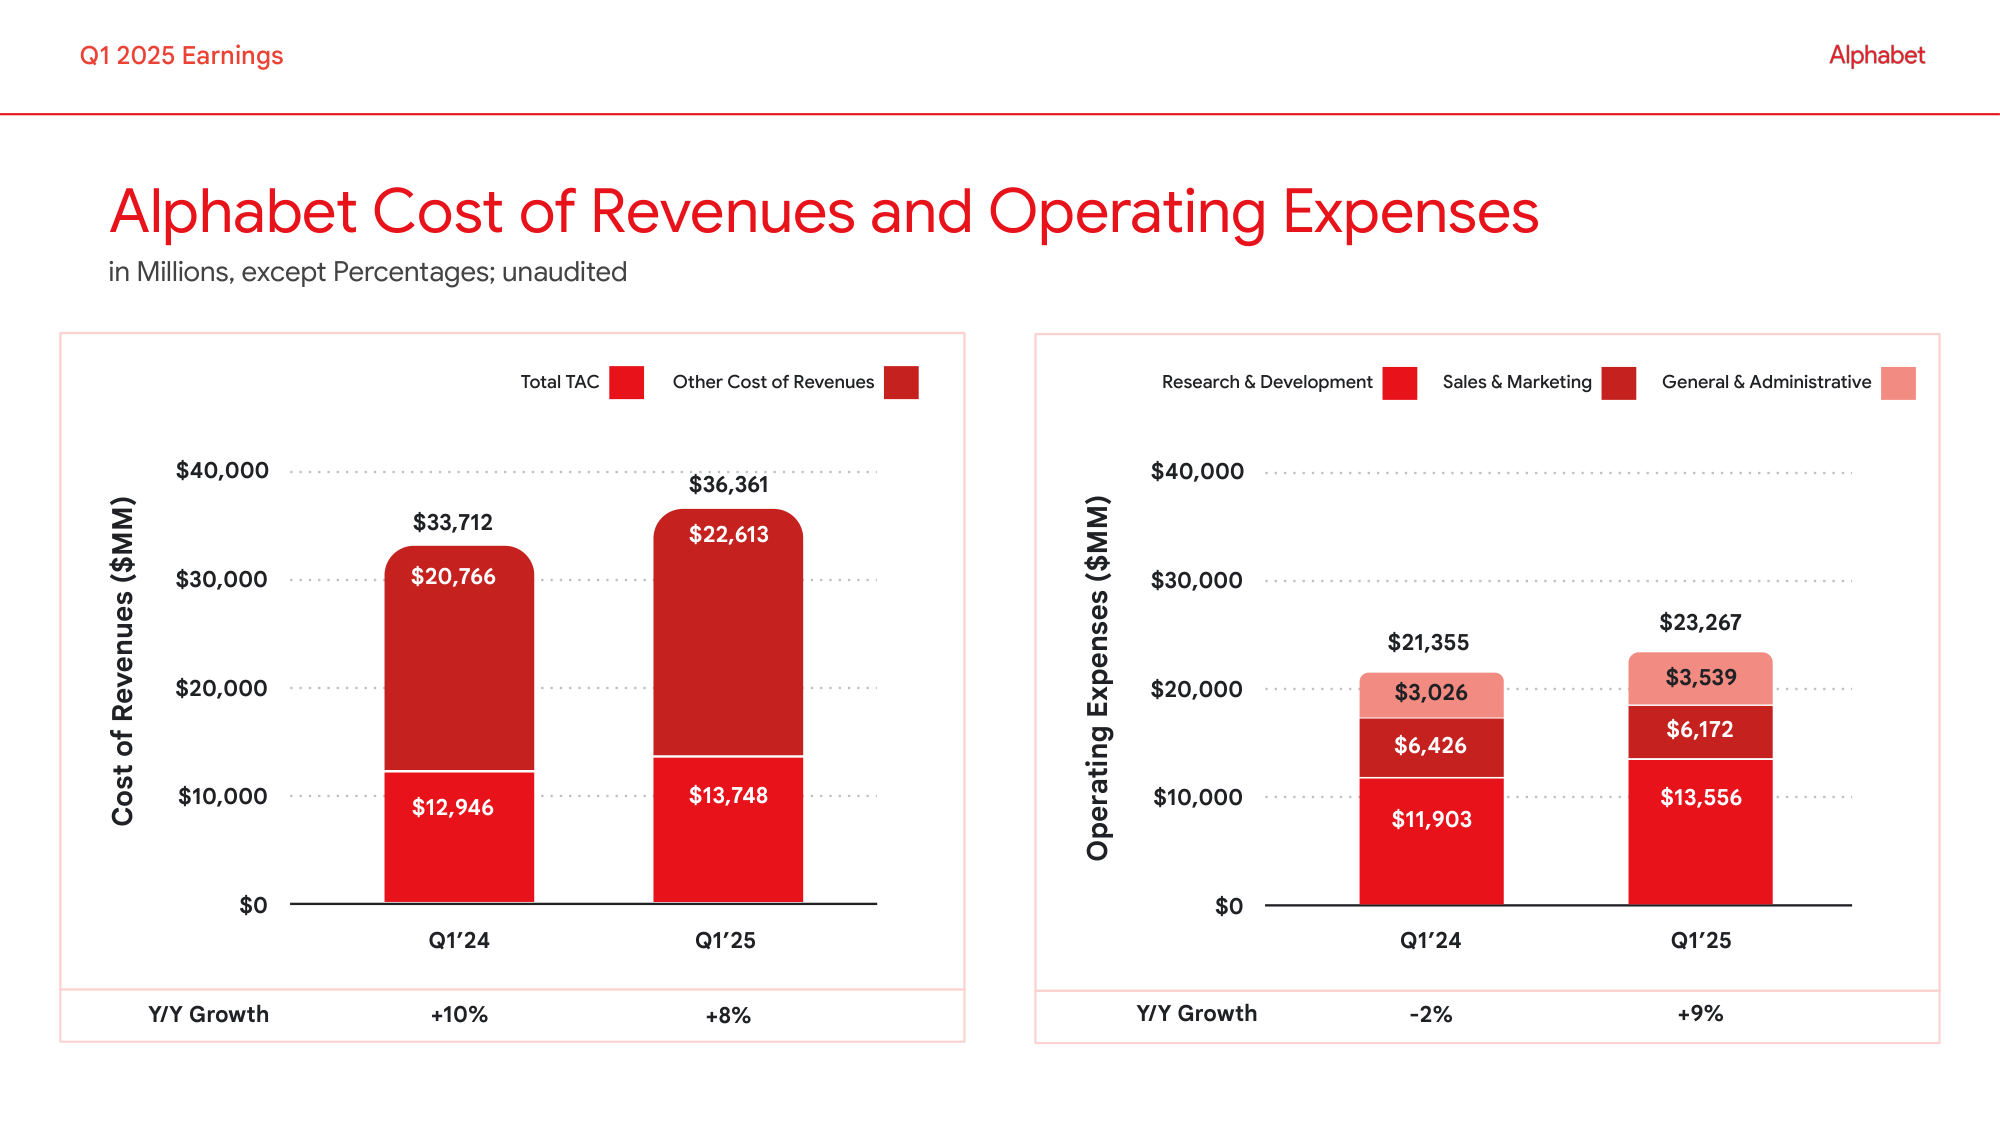

In [ ]:
from PIL import Image
IMAGE_INDEX = "00-data/base/faiss_image_index"
IMAGE_META  = "00-data/base/faiss_image_metadata.json"

image_retriever = ImageRetriever(IMAGE_INDEX, IMAGE_META)
query = "What are the operating expenses?"
results = image_retriever.search(query, k=5)
results
path = results[0]["metadata"]["image_path"]
Image.open(path)


## Unified Agent Query Response

In [ ]:
from UnifiedCFOAgent import create_cfo_agent

cfo_agent = create_cfo_agent()

query = "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."

response = cfo_agent.invoke({"input": query})

print(response)

## 8. Results & Plots

Show baseline vs optimized. Include latency plots (p50/p95) and accuracy tables.

In [ ]:
# TODO: Generate plots with matplotlib
